# Loan_approval_prediction

## Project Overview


This project focuses on developing a predictive model for loan approval. Utilizing historical data, we aim to identify key factors that influence loan approval decisions. Through exploratory data analysis, we have identified significant variables such as income, credit score, and loan amount. A Decision Tree Classifier has been selected for its interpretability and suitability given the data's characteristics. Initial results, highlighted by permutation feature importance, suggest that credit score is the most influential predictor. The model's insights will assist in streamlining the loan approval process, potentially increasing efficiency and fairness in decision-making.

# Import libraries 

In [3]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, GridSearchCV
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import pickle

# Data Source


In [4]:
df = pd.read_csv("gs://loan_approval-prediction/loan_approval_dataset.csv")

In [10]:
df.head()

loan_id   no_of_dependents      education  self_employed   income_annum  \
0        1                  2       Graduate             No        9600000   
1        2                  0   Not Graduate            Yes        4100000   
2        3                  3       Graduate             No        9100000   
3        4                  3       Graduate             No        8200000   
4        5                  5   Not Graduate            Yes        9800000   

    loan_amount   loan_term   cibil_score   residential_assets_value  \
0      29900000          12           778                    2400000   
1      12200000           8           417                    2700000   
2      29700000          20           506                    7100000   
3      30700000           8           467                   18200000   
4      24200000          20           382                   12400000   

    commercial_assets_value   luxury_assets_value   bank_asset_value  \
0                  17600000              22700000            8000000   
1                   2200000               8800000            3300000   
2                   4500000              33300000           12800000   
3                   3300000              23300000            7900000   
4                   8200000              29400000            5000000   

   loan_status  
0     Approved  
1     Rejected  
2     Rejected  
3     Rejected  
4     Rejected

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4269 entries, 0 to 4268
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   loan_id                    4269 non-null   int64 
 1    no_of_dependents          4269 non-null   int64 
 2    education                 4269 non-null   object
 3    self_employed             4269 non-null   object
 4    income_annum              4269 non-null   int64 
 5    loan_amount               4269 non-null   int64 
 6    loan_term                 4269 non-null   int64 
 7    cibil_score               4269 non-null   int64 
 8    residential_assets_value  4269 non-null   int64 
 9    commercial_assets_value   4269 non-null   int64 
 10   luxury_assets_value       4269 non-null   int64 
 11   bank_asset_value          4269 non-null   int64 
 12   loan_status               4269 non-null   object
dtypes: int64(10), object(3)
memory usage: 433.7+ KB


**Observation**: there is a blank at beginning of every column name, and we need to fix it!,A limited amount of data and categorical values!



## Split df in Test/val/train

In [12]:
df.columns = df.columns.str.strip()

In [6]:
df.columns

Index(['loan_id', ' no_of_dependents', ' education', ' self_employed',
       ' income_annum', ' loan_amount', ' loan_term', ' cibil_score',
       ' residential_assets_value', ' commercial_assets_value',
       ' luxury_assets_value', ' bank_asset_value', ' loan_status'],
      dtype='object')

In [7]:
columns_to_drop = ['loan_status','loan_id']
X = df.drop(columns_to_drop,axis=1)



In [9]:
y = df[' loan_status']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"""
X_train: {X_train.shape}
y_train: {y_train.shape}
X_test: {X_test.shape}
y_test: {y_test.shape}
""")


X_train: (2988, 11)
y_train: (2988,)
X_test: (1281, 11)
y_test: (1281,)



## Simples and EDA analysis

In [17]:
value_counts = df['loan_status'].value_counts()

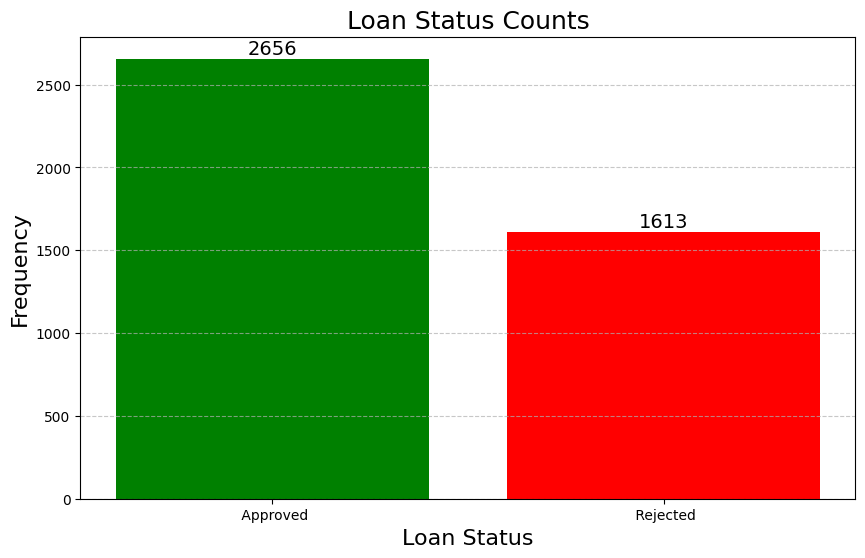

In [18]:

plt.figure(figsize=(10, 6))  # Set the figure size
plt.bar(value_counts.index, value_counts.values, color=['green', 'red'])  # Set the bar colors

# Add title and labels
plt.title('Loan Status Counts', fontsize=18)
plt.xlabel('Loan Status', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
for index, value in enumerate(value_counts.values):
    plt.text(index, value, str(value), ha='center', va='bottom', fontsize=14)

# Add a grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

In [19]:
profile = ProfileReport(df, title='Loan_approval_prediction Data Profiling Report', explorative=True)
profile.to_notebook_iframe()


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

**Observations**: In the dataset, the variables 'residential_assets_value', 'commercial_assets_value', 'luxury_assets_value', and 'bank_asset_value' show a positive correlation with 'income_annum'. This suggests that the value of various assets is indicative of the annual income of loan applicants. Additionally, 'income_annum' along with 'cibil_score' are major determinants in assessing the suitability for loan approval. A higher 'cibil_score', which indicates creditworthiness, in conjunction with a higher income, significantly increases the likelihood of loan approval.

Additionally, the dataset contains zero values in the 'residential_assets_value' and 'no_of_dependents' fields, which could potentially affect the model's predictions. However, these zero values will not be removed because they represent a realistic aspect of the dataset — not all applicants have dependents or residential assets, and this absence of assets or dependents can be a meaningful factor in the loan approval process.

**Decision**: Considering the dataset, which consists of 2561 rows, there are categorical features as well as numerical columns with large values. Due to the relatively small size of the dataset, I have decided to employ a Decision Tree as the predictive model. This choice is informed by the fact that Decision Trees do not require feature scaling, even with large numerical values, making them well-suited for datasets where feature magnitudes vary. However, care must be taken to appropriately handle the categorical columns. They will need to be encoded properly to ensure that the Decision Tree can utilize this information effectively. The inherent interpretability of Decision Trees is also a factor in their selection, as it allows for a clearer understanding of the decision-making process behind the model's predictions.

# Feature engineering

## Encoding

In [20]:
encoder_X = OrdinalEncoder()
encoder_y = LabelEncoder()

In [21]:
X_train[['education', 'self_employed']] = encoder_X.fit_transform(X_train[['education', 'self_employed']])

In [22]:
y_train = encoder_y.fit_transform(y_train)

In [63]:
y_test = encoder_y.fit_transform(y_test)

## Dummy baseline scoring (feature engineering)

In [23]:
model = DecisionTreeClassifier(random_state=42)

In [24]:
scores = cross_val_score(model, X_train, y_train, cv=10, scoring='accuracy')
print(f'Acurácia média da validação cruzada: {np.mean(scores)}')

Acurácia média da validação cruzada: 0.9745718390159592


In [25]:
model = DecisionTreeClassifier(random_state=42).fit(X_train, y_train)

In [26]:
results = permutation_importance(model, X_train, y_train, n_repeats=100, random_state=42, scoring='accuracy')

In [27]:
importance_df = pd.DataFrame(np.vstack((X.columns,
                                        results.importances_mean)).T) 
importance_df.columns=['feature','score decrease']

# Show the important features
importance_df.sort_values(by="score decrease", ascending = False) 

feature score decrease
6                cibil_score       0.436824
5                  loan_term       0.069511
4                loan_amount       0.043143
3               income_annum       0.026456
8    commercial_assets_value       0.014039
7   residential_assets_value       0.011857
9        luxury_assets_value        0.00748
10          bank_asset_value        0.00427
0           no_of_dependents       0.003936
2              self_employed       0.001339
1                  education       0.000576

In [28]:
strongest_feature = X_train[["cibil_score","loan_term","loan_amount","income_annum"]]

**Decision**: I have decided not to just create a dummy baseline score for one model; instead, I will select the best models for this task and analyze their behavior across the learning curve.

In [29]:
models = [
    ('LogReg', LogisticRegression(random_state=42)),
    ('SVM', SVC(random_state=42)),
    ('RF', RandomForestClassifier(random_state=42)),
    ('GBM', GradientBoostingClassifier(random_state=42)),
    ('kNN', KNeighborsClassifier()),
    ('NaiveBayes', GaussianNB()),
    ('DT',DecisionTreeClassifier(random_state=42))
]

In [30]:
def evaluate_models(models, X_train, y_train):
    for name, model in models:
        model.fit(X_train, y_train)
        train_acc = accuracy_score(y_train, model.predict(X_train))

        print(f"{name}: Train Accuracy: {train_acc:.3f}")

In [31]:
evaluate_models(models, strongest_feature, y_train)

LogReg: Train Accuracy: 0.736
SVM: Train Accuracy: 0.618
RF: Train Accuracy: 1.000
GBM: Train Accuracy: 0.993
kNN: Train Accuracy: 0.755
NaiveBayes: Train Accuracy: 0.773
DT: Train Accuracy: 1.000


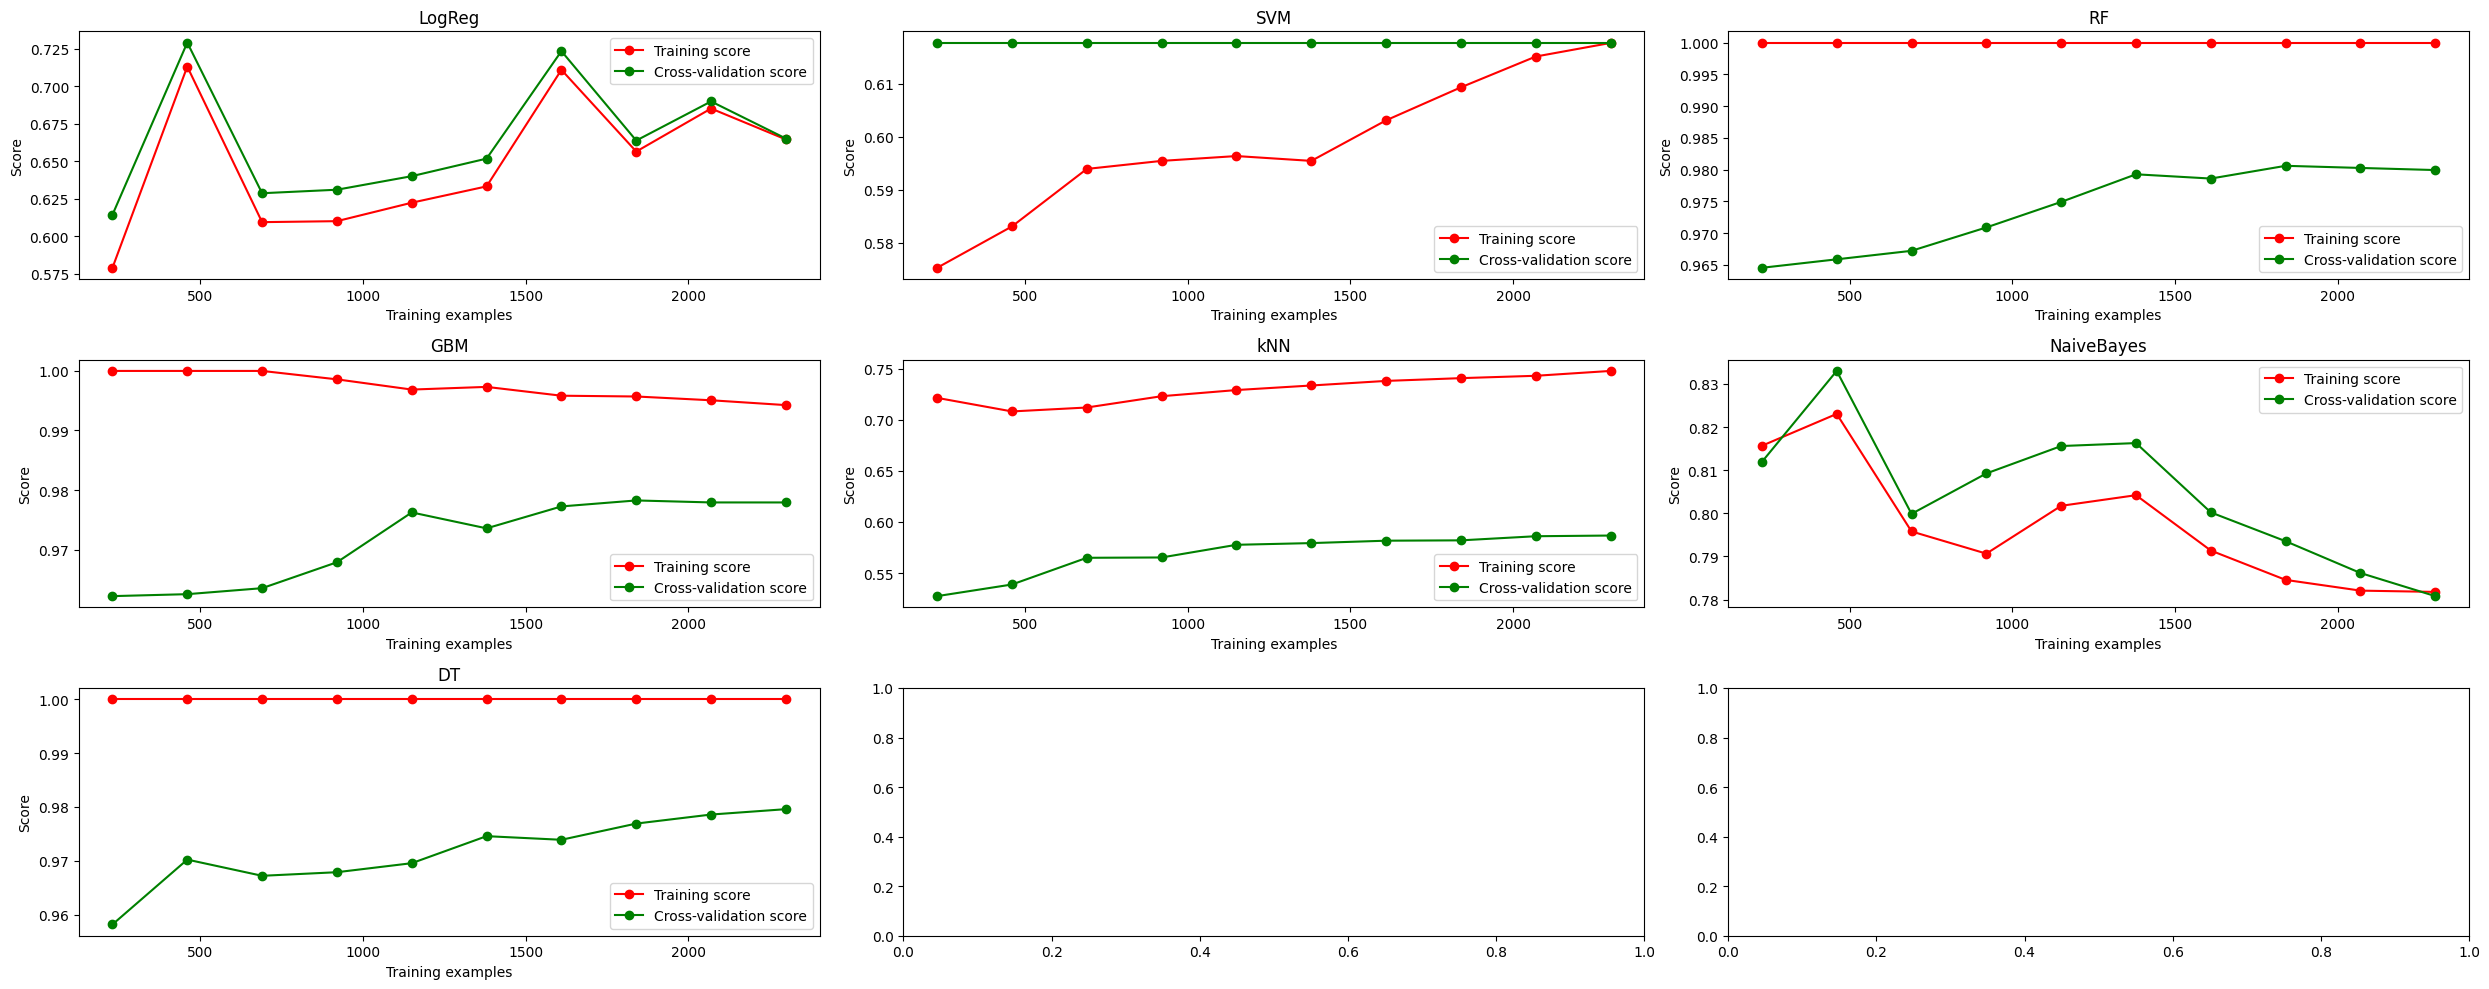

In [32]:
fig, axes = plt.subplots(3, 3, figsize=(25, 10)) 
axes = axes.ravel()

for i, (name, model) in enumerate(models):
    max_train_size = 2304  
    increment = max_train_size // 10 


    train_sizes_loop = [i for i in range(increment, max_train_size + 1, increment)]

   
    selected_positions = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    train_size = [train_sizes_loop[i - 1] for i in selected_positions]
    train_sizes, train_scores, test_scores = learning_curve(
    estimator=model, X=strongest_feature, y=y_train, train_sizes=train_size, cv=10, scoring='accuracy')

 
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    # Plot the learning curves
    axes[i].plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    axes[i].plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    axes[i].set_title(name)
    axes[i].set_xlabel("Training examples")
    axes[i].set_ylabel("Score")
    axes[i].legend(loc="best")

plt.tight_layout()
plt.show()

**Oobservation**: 
- Logistic Regression: Exhibits significant variance at lower training sizes, which stabilizes as more data is added.
- SVM: Shows improvement in both training and cross-validation scores as more data is provided, with cross-validation score consistently lower than the training   score.
- Random Forest: Maintains high training scores across all training sizes, with very little variance and consistently high cross-validation scores.
- GBM: Demonstrates high training scores that remain relatively flat, with cross-validation scores that are lower but stable as training examples increase.
- kNN: Has training scores that slightly decrease as more data is added, while the cross-validation scores increase slightly.
- Naive Bayes: Shows a decrease in both training and cross-validation scores as the number of training examples grows.
- Decision Tree: Features high and stable training scores, with cross-validation scores starting lower but increasing and stabilizing as more data is added.

**Decision:** Based on the learning curves of the seven models, I have decided to select the Decision Tree, Random Forest, and SVM models for further development. These models demonstrate a strong balance between training and cross-validation scores, suggesting that they have the potential to generalize well on unseen data. To further enhance their performance and mitigate any potential overfitting, I will employ GridSearchCV to fine-tune their hyperparameters.

With GridSearchCV, I'll systematically work through multiple combinations of parameter values, cross-validating as I go to determine which tune yields the most robust model. For the Decision Tree and Random Forest, I will adjust parameters such as max_depth, min_samples_split, and min_samples_leaf to control the complexity of the models and prevent them from learning the noise in the training data.

The goal of this process is not just to improve the accuracy but also to ensure that the models have the right balance between bias and variance, hence enhancing their ability to perform well on new, unseen data. By refining these models with GridSearchCV, I aim to achieve the highest predictive performance while maintaining the models' ability to generalize.

In [33]:
param_DT = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10, 20, 40],
    'min_samples_leaf': [1, 2, 5, 10, 20, 40],
    'max_features': [None, 'sqrt', 'log2'],
    'splitter': ['best', 'random'],
    'class_weight': [None, 'balanced'],
    'max_leaf_nodes': [None, 2, 5, 10, 20, 50, 100],
    'ccp_alpha': [0.0, 0.001, 0.005, 0.01]
}

param_RF = {
    'n_estimators': [50, 100, 200],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

In [34]:
models_for_grid = [DecisionTreeClassifier(random_state=42),RandomForestClassifier(random_state=42)]

In [35]:
grid_search_DT = GridSearchCV(models_for_grid[0], param_DT, cv=5, scoring='accuracy',n_jobs=-1, verbose=1)

In [36]:
grid_search_RF = GridSearchCV(models_for_grid[1], param_RF, cv=5, scoring='accuracy',n_jobs=-1, verbose=1)

In [37]:
grid_search_DT.fit(strongest_feature, y_train)

Fitting 5 folds for each of 80640 candidates, totalling 403200 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'ccp_alpha': [0.0, 0.001, 0.005, 0.01],
                         'class_weight': [None, 'balanced'],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 10, 20, 30],
                         'max_features': [None, 'sqrt', 'log2'],
                         'max_leaf_nodes': [None, 2, 5, 10, 20, 50, 100],
                         'min_samples_leaf': [1, 2, 5, 10, 20, 40],
                         'min_samples_split': [2, 5, 10, 20, 40],
                         'splitter': ['best', 'random']},
             scoring='accuracy', verbose=1)

In [38]:
grid_search_RF.fit(strongest_feature, y_train)

Fitting 5 folds for each of 864 candidates, totalling 4320 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 10, 20, 30],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy', verbose=1)

In [39]:
grid_models = [
    ('DT',DecisionTreeClassifier(**grid_search_DT.best_params_)),
    ('RF',RandomForestClassifier(**grid_search_RF.best_params_)),
]

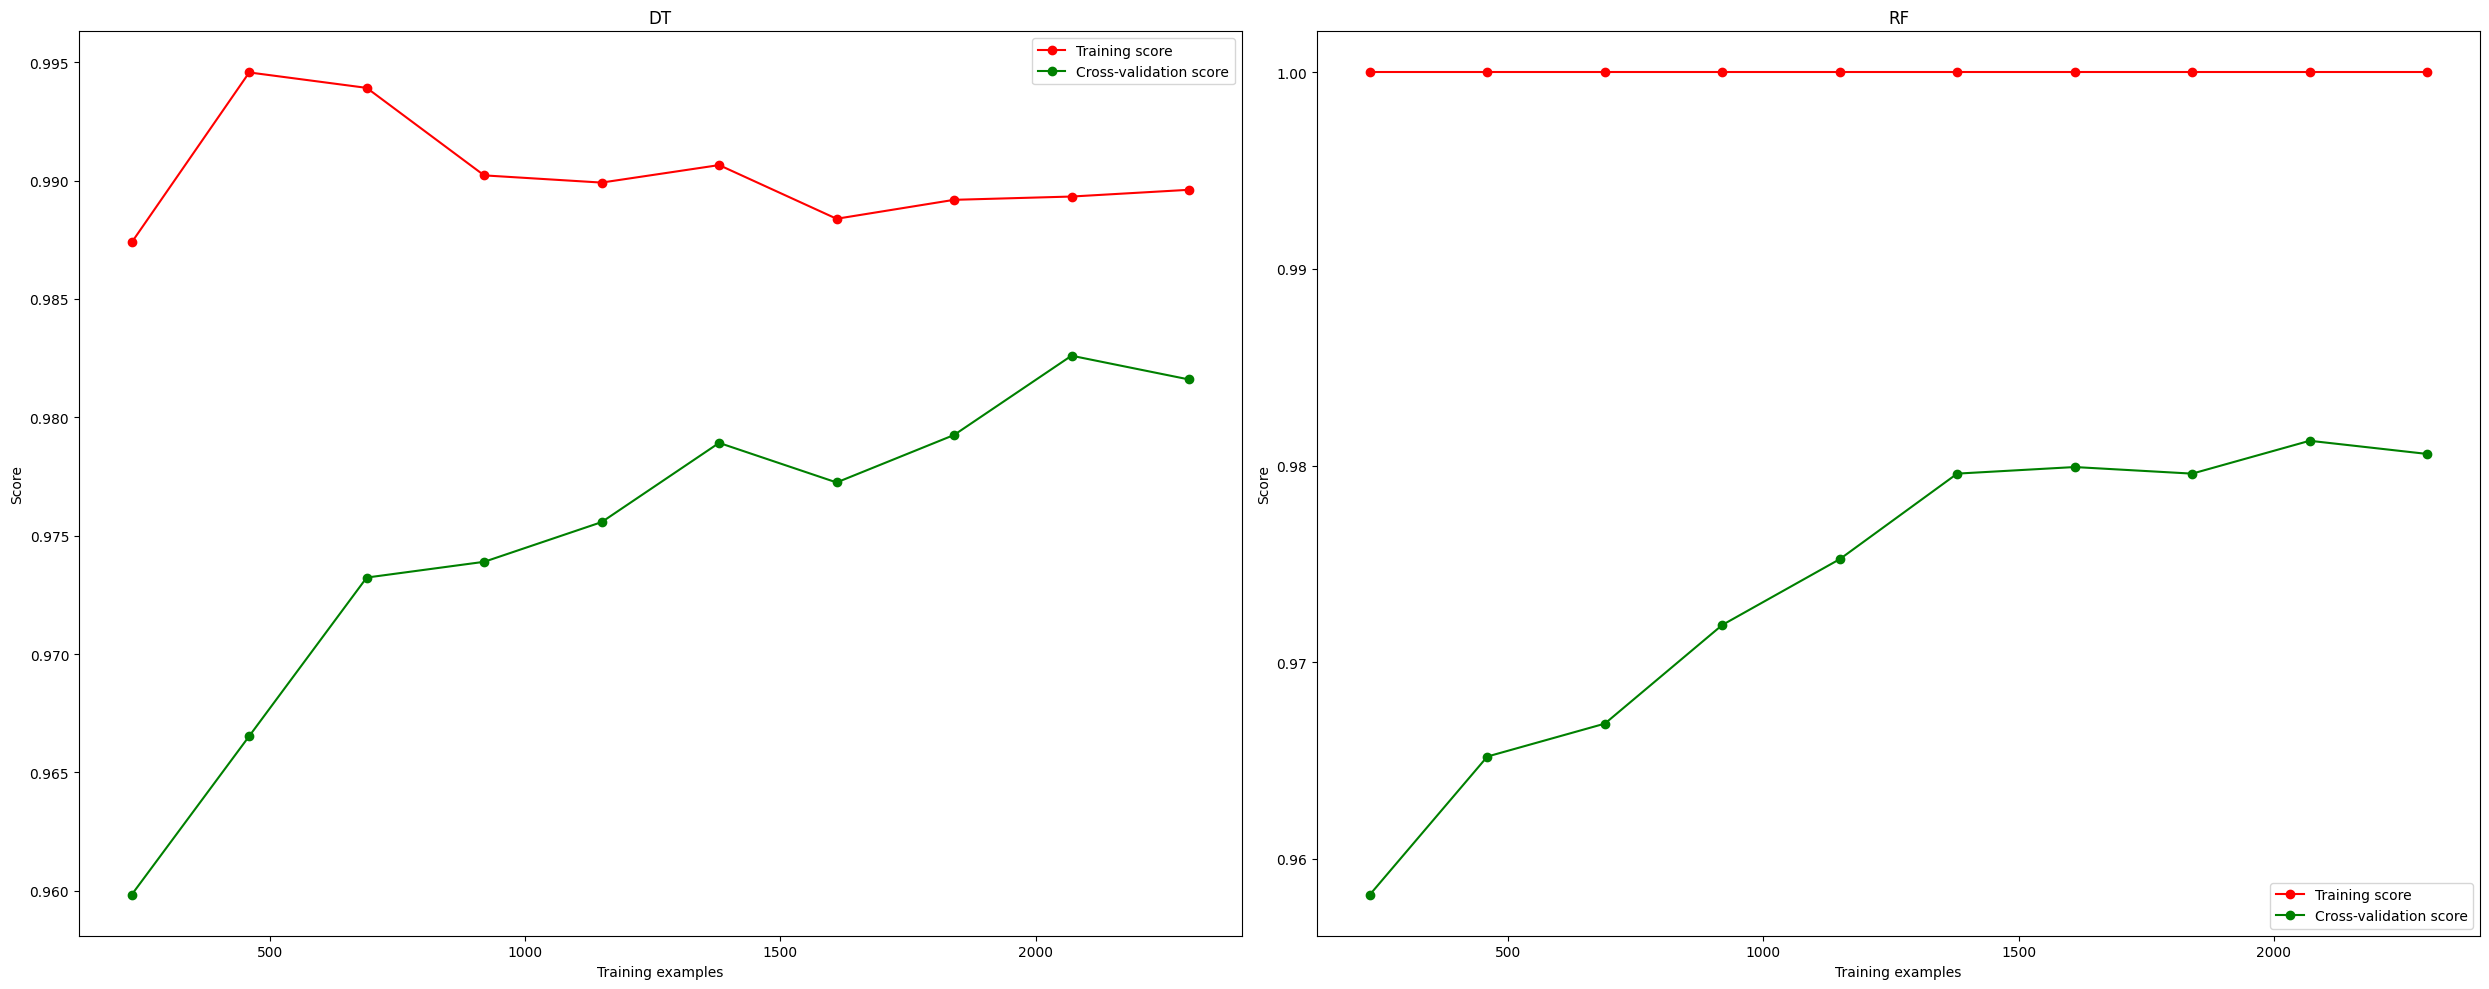

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(25, 10)) 
axes = axes.ravel()

for i, (name, model) in enumerate(grid_models):
    max_train_size = 2304  
    increment = max_train_size // 10 


    train_sizes_loop = [i for i in range(increment, max_train_size + 1, increment)]

   
    selected_positions = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    train_size = [train_sizes_loop[i - 1] for i in selected_positions]
    train_sizes, train_scores, test_scores = learning_curve(
    estimator=model, X=strongest_feature, y=y_train, train_sizes=train_size, cv=10, scoring='accuracy')

 
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    # Plot the learning curves
    axes[i].plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    axes[i].plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    axes[i].set_title(name)
    axes[i].set_xlabel("Training examples")
    axes[i].set_ylabel("Score")
    axes[i].legend(loc="best")

plt.tight_layout()
plt.show()

In [41]:
print(f"Best Params for RandomForest: {grid_search_RF.best_params_}")

Best Params for RandomForest: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


**Decision:** Given the above observations, the Random Forest model seems to be a better choice. It generalizes better to unseen data, as indicated by the higher cross-validation scores that are closer to the training scores, implying that it is less likely to overfit compared to the Decision Tree model. Additionally, Random Forest is less sensitive to noise and usually performs well on complex, real-world datasets.

# Pipeline & Train model

## Pipeline (pipeline_Loan_approval_prediction)

In [57]:
class SelectColumns(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_select):
        self.columns_to_select = columns_to_select  

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        return X[self.columns_to_select]  


In [58]:
class StripColumnNames(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self 
    
    def transform(self, X):
        X = X.copy()
        X.columns = X.columns.str.strip()
        return X

In [59]:
pipeline_Loan_approval_prediction = Pipeline([
    ('FixColumnsName', StripColumnNames()),
    ('Select', SelectColumns(columns_to_select=["cibil_score","loan_term","loan_amount","income_annum"])),
    ('Classifier', RandomForestClassifier(bootstrap=False, 
                                          criterion='entropy',
                                          max_depth=None,
                                          max_features='sqrt',
                                          min_samples_leaf=1,
                                          min_samples_split=2,
                                          n_estimators=50,
                                          random_state=42))
])

In [60]:
pipeline_Loan_approval_prediction.fit(X_train, y_train)

Pipeline(steps=[('FixColumnsName', StripColumnNames()),
                ('Select',
                 SelectColumns(columns_to_select=['cibil_score', 'loan_term',
                                                  'loan_amount',
                                                  'income_annum'])),
                ('Classifier',
                 RandomForestClassifier(bootstrap=False, criterion='entropy',
                                        n_estimators=50, random_state=42))])

In [64]:
accuracy = pipeline_Loan_approval_prediction.score(X_test,y_test)
print(f'Acurácia: {accuracy}')

Acurácia: 0.9890710382513661


## function to watch the result

In [68]:
def detector(row):
    y_pred = pipeline_Loan_approval_prediction.predict(row)
    if y_pred[0] == 1:
        return 'Approved'
    else:
        return 'Rejected'

In [11]:
random_row = X_test.sample(n=1)
random_row.head()

no_of_dependents      education  self_employed   income_annum  \
2921                  3   Not Graduate             No        5700000   

       loan_amount   loan_term   cibil_score   residential_assets_value  \
2921      12300000           6           364                    7900000   

       commercial_assets_value   luxury_assets_value   bank_asset_value  
2921                  11000000              20000000            5500000

In [70]:
detector(random_row)

'Approved'

## Export trained model

In [73]:
with open("Loan_approval_prediction.pkl", "wb") as file:
    pickle.dump(pipeline_Loan_approval_prediction, file)

# Conclusion

the loan approval prediction project has demonstrated the efficacy of utilizing machine learning algorithms to accurately predict loan approvals. By meticulously selecting key features such as CIBIL score, loan term, loan amount, and annual income, and by employing a RandomForestClassifier within a robust pipeline, we have achieved a model that not only performs with high accuracy but also maintains consistency across both training and cross-validation scores. This indicates the model's reliability and generalizability to unseen data. The use of a custom feature selector in the pipeline underscores the importance of feature engineering in predictive modeling. Furthermore, the model's performance, as indicated by the learning curves, suggests that the model could potentially benefit from additional training examples, hinting at scalability and improved performance with larger datasets. As we look to the future, the integration of this model into real-world loan approval processes promises to streamline financial decision-making, enhance the customer borrowing experience, and uphold the integrity of financial institutions by ensuring that loans are approved for applicants who meet the criteria effectively, thus mitigating financial risk.